In [37]:
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats

In [2]:
import dynchro

# 1. Data loading

In [3]:
adata = ad.read_h5ad("data/processed_wildtype.h5ad")
irf8 = ad.read_h5ad("data/processed_irf8.h5ad")
gfi1 = ad.read_h5ad("data/processed_gfi1.h5ad")
both = ad.read_h5ad("data/processed_both.h5ad")

In [4]:
lineages = {"erythrocytic": [2, 1], "monocytic": [2, 0, 4], "granulocytic": [2, 0, 3]}
adata, irf8, gfi1, both, lineages

(AnnData object with n_obs × n_vars = 382 × 500
     obs: 'label', 'n_counts', 'n_genes', 'pct_genes', 'kmeans', 'node', 'branch_id', 'branch_id_alias', 'branch_lam', 'branch_dist', 'S0_pseudotime', 'S3_pseudotime', 'S5_pseudotime', 'S4_pseudotime', 'S2_pseudotime', 'S1_pseudotime', 'branch_id_id', 'pseudotime', 'milestones'
     var: 'n_counts', 'n_cells', 'pct_cells'
     uns: 'branch_id_alias_colors', 'label_colors', 'lineages', 'var_genes', 'workdir'
     obsm: 'X_dr', 'X_mlle', 'X_spring', 'X_stream_S4', 'X_vis', 'X_vis_umap',
 AnnData object with n_obs × n_vars = 62 × 500
     obs: 'label', 'pseudotime'
     uns: 'label_color', 'label_colors', 'params', 'var_genes', 'workdir'
     obsm: 'X_dr', 'X_mlle', 'X_pca', 'X_vis', 'X_vis_umap', 'var_genes',
 AnnData object with n_obs × n_vars = 79 × 500
     obs: 'label', 'pseudotime'
     uns: 'label_color', 'label_colors', 'params', 'var_genes', 'workdir'
     obsm: 'X_dr', 'X_mlle', 'X_pca', 'X_vis', 'X_vis_umap', 'var_genes',
 AnnData

# 2. Dynchro

## 2.1 Prep samples

In [5]:
# Run lineage prep on adata
adata.uns["id"] = "wildtype"
adata.uns["lineages"] = lineages
adata.obs["milestones"] = adata.obs["branch_id_id"]
for name, labels in lineages.items():
    adata = dynchro.pp.label_lineage(adata, "milestones", labels, name)
for name, labels in lineages.items():
    adata = dynchro.pp.calculate_pseudocells(adata, 50, name)
adata = dynchro.pp.merge_pseudocells_lineages(adata, list(lineages.keys()), 50)
adata

/home/louise/Work/dynchro/src/dynchro/pp/pseudocells.py:53: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[f"transition_matrix_{amount}"] = np.array(
/home/louise/Work/dynchro/src/dynchro/pp/pseudocells.py:108: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pseudotimes_sorted = pseudotimes[np.argsort(pseudotimes)]
/home/louise/Work/dynchro/src/dynchro/pp/pseudocells.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cur_score = scipy.stats.percentileofscore(cell_pseudotime, pseudotimes_sorted[cur])
/home/louise/Work/dynchro/src/dynchro/pp/pseudocell

AnnData object with n_obs × n_vars = 382 × 500
    obs: 'label', 'n_counts', 'n_genes', 'pct_genes', 'kmeans', 'node', 'branch_id', 'branch_id_alias', 'branch_lam', 'branch_dist', 'S0_pseudotime', 'S3_pseudotime', 'S5_pseudotime', 'S4_pseudotime', 'S2_pseudotime', 'S1_pseudotime', 'branch_id_id', 'pseudotime', 'milestones', 'erythrocytic', 'monocytic', 'granulocytic'
    var: 'n_counts', 'n_cells', 'pct_cells'
    uns: 'branch_id_alias_colors', 'label_colors', 'lineages', 'var_genes', 'workdir', 'id', 'lineage_labels', 'pseudocells_50_erythrocytic_pseudotime', 'pseudocells', 'pseudocells_50_monocytic_pseudotime', 'pseudocells_50_granulocytic_pseudotime'
    obsm: 'X_dr', 'X_mlle', 'X_spring', 'X_stream_S4', 'X_vis', 'X_vis_umap'
    varm: 'pseudocells_50_erythrocytic', 'pseudocells_50_monocytic', 'pseudocells_50_granulocytic'

In [6]:
# Run lineage prep on irf8, gfi1, both
irf8.uns["id"] = "irf8"
gfi1.uns["id"] = "gfi1"
both.uns["id"] = "both"

for a in [irf8, gfi1, both]:
    a.uns["lineages"] = lineages
    a.obs["milestones"] = 1
    a = dynchro.pp.label_lineage(a, "milestones", [1], a.uns["id"])
    a = dynchro.pp.calculate_pseudocells(a, 50, a.uns["id"])

irf8, gfi1, both

/home/louise/Work/dynchro/src/dynchro/pp/pseudocells.py:53: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[f"transition_matrix_{amount}"] = np.array(
/home/louise/Work/dynchro/src/dynchro/pp/pseudocells.py:53: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[f"transition_matrix_{amount}"] = np.array(
/home/louise/Work/dynchro/src/dynchro/pp/pseudocells.py:53: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[f"transition_matrix_{amount}"] = np.array(


(AnnData object with n_obs × n_vars = 62 × 500
     obs: 'label', 'pseudotime', 'milestones', 'irf8'
     uns: 'label_color', 'label_colors', 'params', 'var_genes', 'workdir', 'id', 'lineages', 'lineage_labels', 'pseudocells_50_irf8_pseudotime', 'pseudocells'
     obsm: 'X_dr', 'X_mlle', 'X_pca', 'X_vis', 'X_vis_umap', 'var_genes'
     varm: 'pseudocells_50_irf8',
 AnnData object with n_obs × n_vars = 79 × 500
     obs: 'label', 'pseudotime', 'milestones', 'gfi1'
     uns: 'label_color', 'label_colors', 'params', 'var_genes', 'workdir', 'id', 'lineages', 'lineage_labels', 'pseudocells_50_gfi1_pseudotime', 'pseudocells'
     obsm: 'X_dr', 'X_mlle', 'X_pca', 'X_vis', 'X_vis_umap', 'var_genes'
     varm: 'pseudocells_50_gfi1',
 AnnData object with n_obs × n_vars = 47 × 500
     obs: 'label', 'pseudotime', 'milestones', 'both'
     uns: 'label_color', 'label_colors', 'params', 'var_genes', 'workdir', 'id', 'lineages', 'lineage_labels', 'pseudocells_50_both_pseudotime', 'pseudocells'
     o

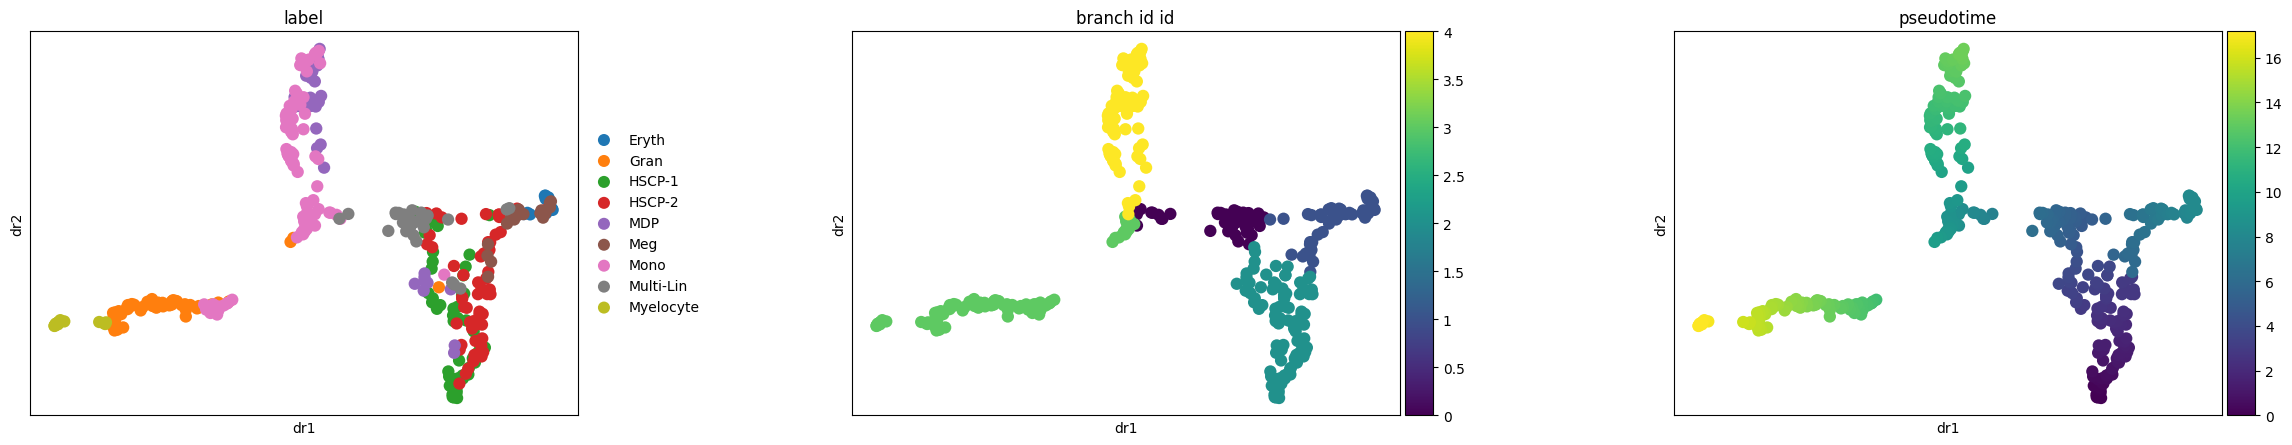

In [7]:
sc.pl.scatter(adata, color=['label', 'branch_id_id', 'pseudotime'], basis='dr')

In [8]:
def calculate_single_correlation(cost_matrix, dist_cells1, dist_cells2):
    distances = []
    for x in dist_cells1:
        for y in dist_cells2:
            distances.append(abs(x-y))
    costs = []
    for i in range(len(cost_matrix)):
        for j in range(len(cost_matrix[i])):
            costs.append(cost_matrix[i][j])

    corr = sp.stats.pearsonr(costs, distances)[0]
    return corr

In [9]:
def run_matching_lineages(data, ko):
    config = {
        "compare_lineages_pseudocells": False,
        "compare_lineages_pseudocells_label": "pseudocells_50",
        "compare_trajectories_pseudocells": False,
        "compare_trajectories_pseudocells_label": "pseudocells_50",
        "align_pseudocells": False,
    }
    res = dynchro.tl.get_matching_lineages([data, ko], config)
    res, data.uns["lineage_labels"]

In [10]:
run_matching_lineages(adata, irf8)
run_matching_lineages(adata, gfi1)
run_matching_lineages(adata, both)

In [11]:
def get_config(trajectories, sort = True):
    config = {
        "compare_lineages_pseudocells": False,
        "compare_lineages_pseudocells_label": "pseudocells_50",
        "compare_trajectories_pseudocells": False,
        "compare_trajectories_pseudocells_label": "pseudocells_50",
        "align_pseudocells": False,
    }


    common_vars = list(set.intersection(*(set(trajectory.var_names) for trajectory in trajectories)))

    lineages = [
        [
            dynchro.tl.get_counts_common_vars(trajectory, config, "compare_trajectories_pseudocells", linlabel, common_vars, get_x = False)
            for linlabel in trajectory.uns["lineage_labels"]
        ]
        for trajectory in trajectories
    ]

    if sort:
        lineages = [[ lin[np.argsort(lin.obs.pseudotime)] for lin in lineages1 ] for lineages1 in lineages]

    return lineages

In [12]:
def plot_cost_distances(cost, distances, path1, path2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(12, 4)
    sns.heatmap(cost, ax=ax1)
    distances = distances[1:, 1:]
    sns.heatmap(distances, ax=ax2)
    plt.scatter(path2, path1, c="white", s=3)
    plt.show()


class DTWResult:
    def __init__(self, id, lin1, lin2, cost, distances, path1, path2, dist):
        self._id = id
        self._lin1 = lin1
        self._lin2 = lin2
        self._cost = cost
        self._distances = distances
        self._path1 = path1
        self._path2 = path2
        self._dist = dist
        self._dist_norm = dist / (lin1.X.shape[0] + lin2.X.shape[0])
        self._dist_norm_path = dist / len(path1)

    def id(self):
        return self._id

    def cost(self):
        return self._cost

    def distances(self):
        return self._distances

    def path1(self):
        return self._path1

    def path2(self):
        return self._path2

    def dist(self):
        return self._dist

    def dist_norm(self):
        return self._dist_norm

    def dist_norm_path(self):
        return self._dist_norm_path

    def get_warping(self):
        return self._path1, self._path2
    
    def __str__(self):
        return f"ID: {self._id}, Normalized distance: {self._dist_norm_path:.2f}"
    
    def __repr__(self):
        return self.__str__()

    def plot_cost_distances(self):
        plot_cost_distances(self._cost, self._distances, self._path1, self._path2)

In [13]:
def plot_comparisons_keep(adata, ko, label_ko, distance_measure = "euclidean", only_keep = None):
    lineages = get_config([adata, ko])

    results = []
    for lineage1, label in zip(lineages[0], adata.uns["lineage_labels"]):
        for lineage2 in lineages[1]:
            total_dist, cost, distances = dynchro.tl.skip_dtw(lineage2.X, lineage1.X, distance = distance_measure)
            path1, path2 = dynchro.tl.skip_traceback(distances)

            result = DTWResult(f"{label} {lineage2.uns["id"]}", lineage1, lineage2, cost, distances, path1, path2, total_dist)
            results.append(result)

            plot_cost_distances(cost, distances, path1, path2)

    return results

In [14]:
adata[adata.obs.branch_id_id.isin([1,2])]

View of AnnData object with n_obs × n_vars = 155 × 500
    obs: 'label', 'n_counts', 'n_genes', 'pct_genes', 'kmeans', 'node', 'branch_id', 'branch_id_alias', 'branch_lam', 'branch_dist', 'S0_pseudotime', 'S3_pseudotime', 'S5_pseudotime', 'S4_pseudotime', 'S2_pseudotime', 'S1_pseudotime', 'branch_id_id', 'pseudotime', 'milestones', 'erythrocytic', 'monocytic', 'granulocytic'
    var: 'n_counts', 'n_cells', 'pct_cells'
    uns: 'branch_id_alias_colors', 'label_colors', 'lineages', 'var_genes', 'workdir', 'id', 'lineage_labels', 'pseudocells_50_erythrocytic_pseudotime', 'pseudocells', 'pseudocells_50_monocytic_pseudotime', 'pseudocells_50_granulocytic_pseudotime'
    obsm: 'X_dr', 'X_mlle', 'X_spring', 'X_stream_S4', 'X_vis', 'X_vis_umap'
    varm: 'pseudocells_50_erythrocytic', 'pseudocells_50_monocytic', 'pseudocells_50_granulocytic'

In [15]:
def plot_comparisons(adata, ko, label_ko, distance_measure = "euclidean"):
    trajectories = [adata, ko]

    # select only relevant part
    lineages = get_config(trajectories)

    results = []
    for lineage1, label in zip(lineages[0], adata.uns["lineage_labels"]):
        for lineage2 in lineages[1]:
            total_dist, cost, distances = dynchro.tl.skip_dtw(lineage2.X, lineage1.X, distance = distance_measure)
            total_dist_norm = total_dist / (lineage1.X.shape[0] + lineage2.X.shape[0])
            path1, path2 = dynchro.tl.skip_traceback(distances)
            print(max(path1), max(path2))

            total_dist_norm2 = total_dist / len(path1)

            pseudotime_d1_l1 = lineage1.obs.pseudotime
            pseudotime_d2_l1 = lineage2.obs.pseudotime
            pseudotime_d1_l1 = pseudotime_d1_l1[np.argsort(pseudotime_d1_l1)]
            pseudotime_d2_l1 = pseudotime_d2_l1[np.argsort(pseudotime_d2_l1)]

            corr = calculate_single_correlation(cost, pseudotime_d1_l1, pseudotime_d2_l1)

            plot_cost_distances(cost, distances, path1, path2)

            results.append(f"{label_ko.upper()},{label},{total_dist},{total_dist_norm},{total_dist_norm2},{corr}")
    # print("KO\tbranch_name\t\ttotal_dist\ttotal_dist_norm\t\ttotal_dist_norm_path\t\tcorr\n")
    print("\n".join(results))

## 2.2 Run dynchro

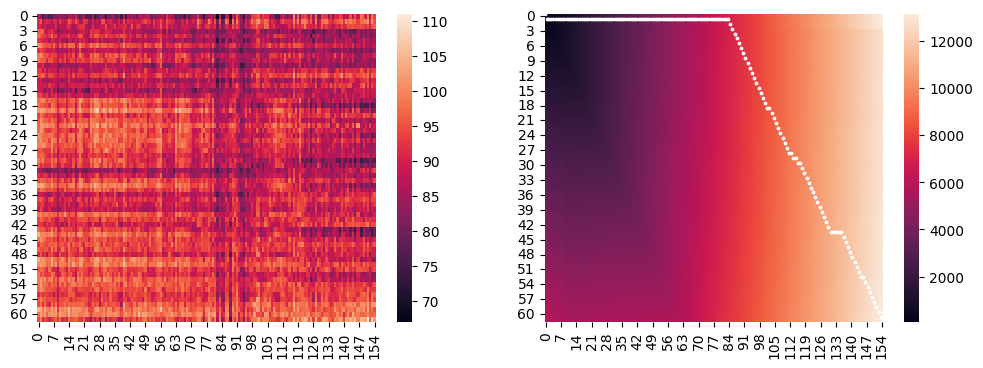

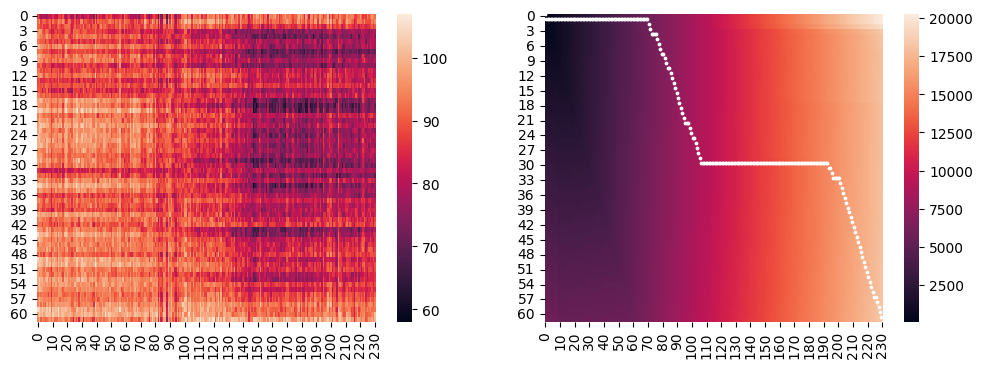

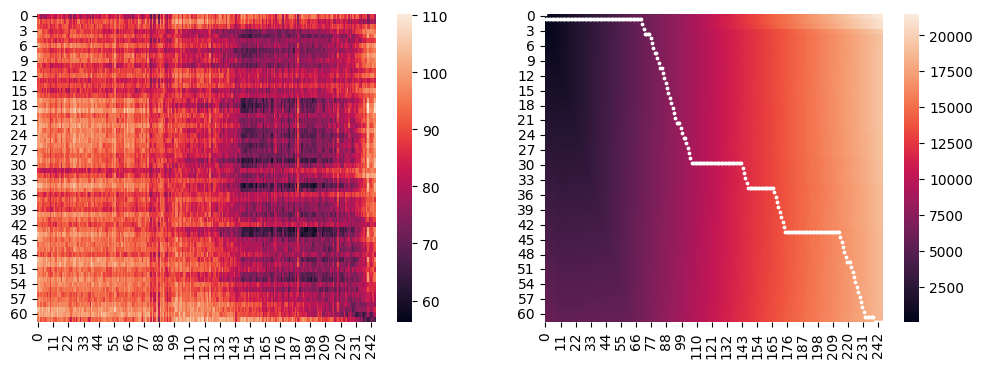

In [16]:
warping_irf8 = plot_comparisons_keep(adata, irf8, "irf8") #granulocytic, nr3

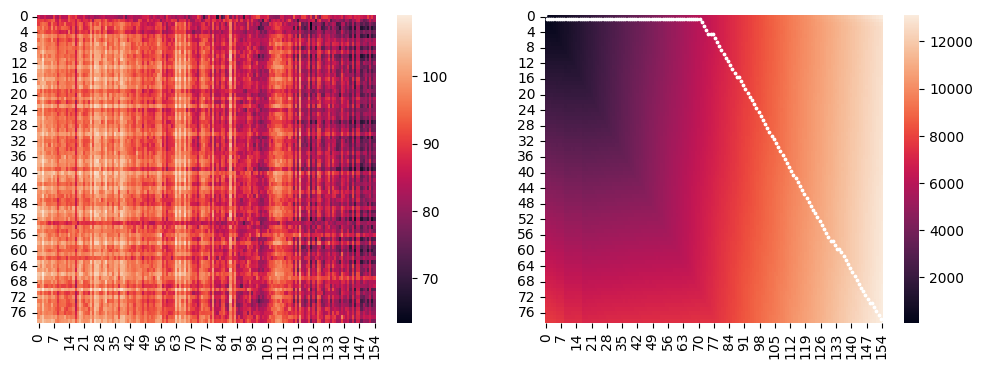

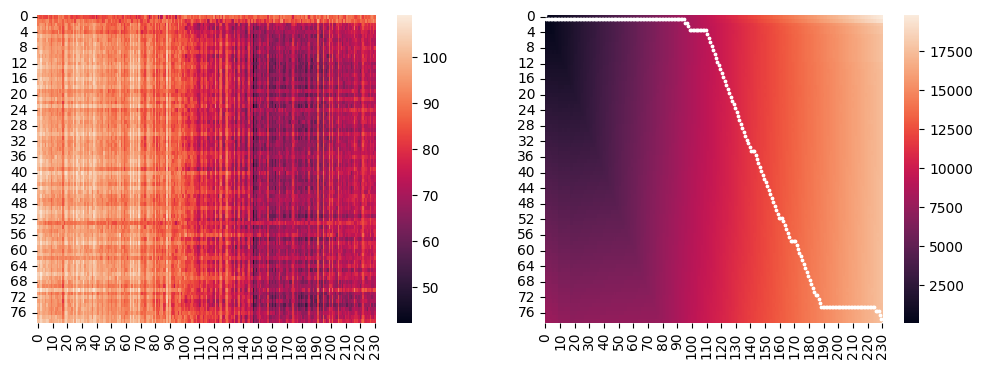

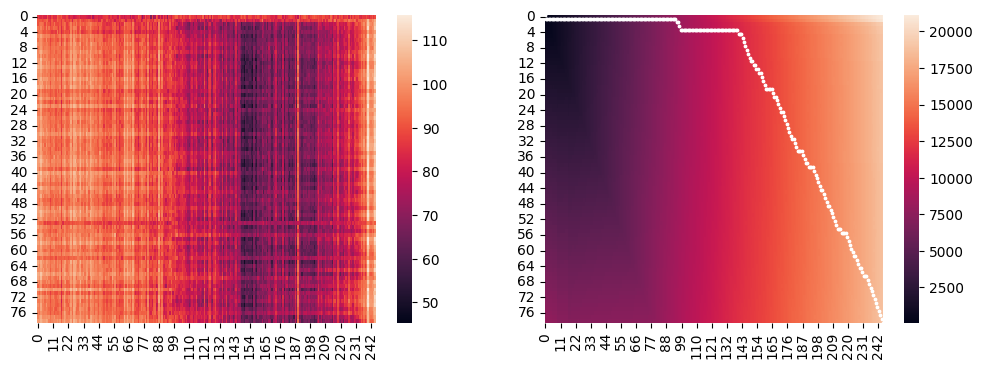

In [17]:
warping_gfi1 = plot_comparisons_keep(adata, gfi1, "gfi1") # == monocytic, nr 2

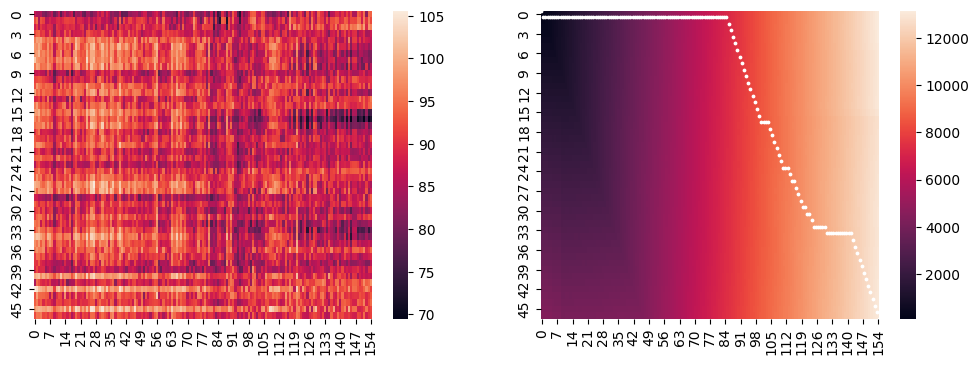

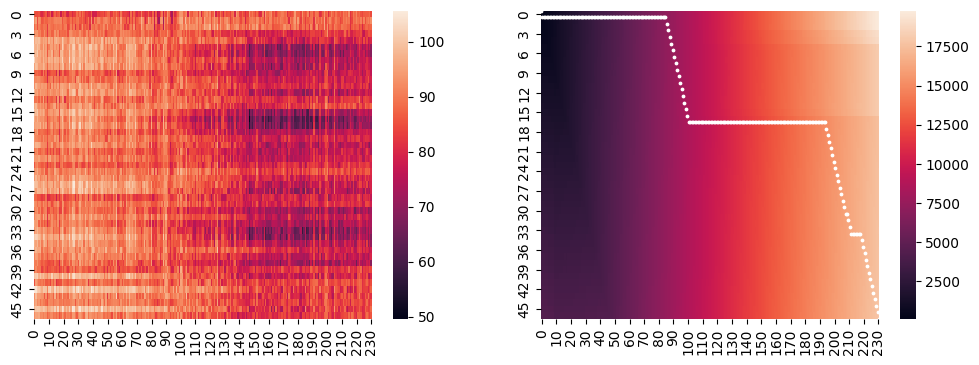

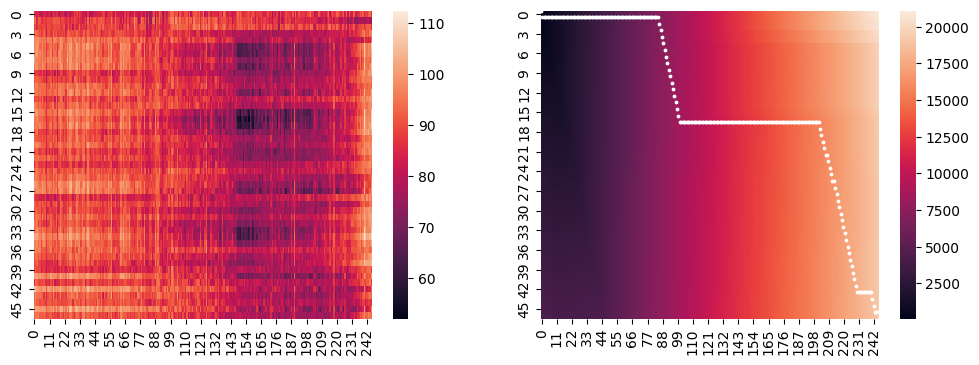

In [18]:
warping_both = plot_comparisons_keep(adata, both, "both") # == none

In [19]:
warping_both

[ID: erythrocytic both, Normalized distance: 83.81,
 ID: monocytic both, Normalized distance: 76.58,
 ID: granulocytic both, Normalized distance: 77.20]

In [20]:
warping_irf8

[ID: erythrocytic irf8, Normalized distance: 84.29,
 ID: monocytic irf8, Normalized distance: 78.60,
 ID: granulocytic irf8, Normalized distance: 75.35]

In [21]:
warping_gfi1

[ID: erythrocytic gfi1, Normalized distance: 84.15,
 ID: monocytic gfi1, Normalized distance: 75.51,
 ID: granulocytic gfi1, Normalized distance: 76.26]

## 2.3 Bootstrap

In [22]:
def dtw_comparisons(lineages, distance_measure = "euclidean"):
    results = []
    for lineage1 in lineages[0]:
        lineage2 = lineages[1][0]
        # print(lineage1)
        # print(lineage2)
        total_dist, cost, distances = dynchro.tl.skip_dtw(lineage2.X, lineage1.X, distance = distance_measure)
        path1, path2 = dynchro.tl.skip_traceback(distances)
        total_dist_norm2 = total_dist / len(path1)

        # print(distances[1:, 1:])

        results.append(total_dist_norm2)

    return results

In [24]:
adata = adata[adata.obs.branch_id_id.isin([0, 1, 3, 4])]

def calculate_distance_irf8(names):
    # subset the data and resample using the names, but ordered along the pseudotime
    # print(names)
    knockout = irf8[names]
    trajectories = [adata, knockout]
    lineages = get_config(trajectories)
    return dtw_comparisons(lineages)

def calculate_distance_gfi1(names):
    # subset the data and resample using the names, but ordered along the pseudotime
    # print(names)
    knockout = gfi1[names]
    trajectories = [adata, knockout]
    lineages = get_config(trajectories)
    return dtw_comparisons(lineages)

def calculate_distance_both(names):
    # subset the data and resample using the names, but ordered along the pseudotime
    # print(names)
    knockout = both[names]
    trajectories = [adata, knockout]
    lineages = get_config(trajectories)
    return dtw_comparisons(lineages)

In [ ]:
tt = irf8.obs_names
res = stats.bootstrap([tt], calculate_distance_irf8, n_resamples= 100, vectorized=False, axis = 0)
res.bootstrap_distribution

array([[87.61872461, 88.11129628, 86.96930337, 86.52766157, 87.71936662,
        87.8486058 , 87.9840248 , 87.01098706, 87.31740936, 86.72189836,
        88.12026644, 87.54911729, 88.36926805, 86.69261395, 86.90064942,
        86.83320408, 87.18323166, 87.90312976, 88.28948923, 86.31564569,
        86.64492299, 87.04772104, 86.83461218, 86.5447106 , 87.17927009,
        88.36213565, 88.33595694, 87.04448637, 88.08992835, 86.5890569 ,
        87.13826769, 87.2943962 , 87.00018152, 86.87096208, 86.40142701,
        86.99127922, 86.5248738 , 86.90746766, 87.07577499, 87.24773745,
        86.89727043, 87.938604  , 88.27669402, 86.72478053, 87.22509601,
        87.44044225, 86.81333453, 87.8437484 , 86.61753272, 87.46149207,
        86.61215835, 86.74146335, 87.24083229, 86.93058721, 88.16697546,
        87.75284087, 86.93178957, 87.52147797, 86.6221419 , 86.53887643,
        87.52461742, 87.58463917, 87.70449199, 88.39745286, 87.50508506,
        87.48864411, 86.97263642, 87.18114372, 87.6

In [27]:
res_gfi1 = stats.bootstrap([gfi1.obs_names], calculate_distance_gfi1, n_resamples = 100, vectorized = False, axis = 0)
res_gfi1.bootstrap_distribution

array([[80.02549777, 80.12668658, 80.77833348, 80.11325387, 80.77707969,
        80.1866824 , 80.81064326, 80.6873663 , 80.38228484, 80.53583819,
        79.8815434 , 80.48429827, 80.17609776, 79.91538062, 80.08848697,
        80.38171334, 80.82198931, 79.4219711 , 80.7156529 , 80.36110836,
        80.27932528, 80.14846849, 79.79318284, 80.04512827, 80.31656455,
        80.14051319, 80.80229317, 80.22143795, 79.64689819, 80.22468599,
        80.04435465, 80.09543706, 80.51812549, 80.73328895, 79.53067843,
        80.544345  , 79.60702877, 80.44751766, 80.28159341, 80.65335671,
        80.544682  , 80.44234555, 80.57144809, 79.30639625, 79.92059781,
        80.14658463, 80.20126448, 80.02505615, 80.21232879, 80.25854491,
        80.60433102, 79.99828547, 79.80031366, 80.3253009 , 80.0605649 ,
        80.13642899, 80.05141349, 79.94882363, 81.51329892, 79.55875924,
        79.87142841, 79.90937972, 80.14318625, 81.05534354, 80.27821547,
        79.51660737, 79.4712063 , 80.44797721, 79.9

In [28]:
res_both = stats.bootstrap([both.obs_names], calculate_distance_both, n_resamples = 100, vectorized = False, axis = 0)
res_both.bootstrap_distribution

array([[86.44958101, 86.45150489, 86.16533878, 85.87031596, 86.19728858,
        86.06112829, 86.72319804, 85.11440379, 86.44199844, 87.28990462,
        86.67712823, 84.87885321, 85.73693143, 85.89896244, 85.43550271,
        85.51562262, 85.60258775, 85.82999019, 85.66205611, 85.94939277,
        86.39872157, 86.00657002, 86.99922392, 86.13792855, 85.42908926,
        86.23607939, 85.28505259, 86.11471917, 85.69700232, 86.35849825,
        86.07167652, 86.13950846, 86.09849141, 86.07757055, 86.04544726,
        86.15652382, 85.95397179, 86.41524661, 86.2806706 , 85.39985093,
        86.38618855, 86.33889832, 85.72201055, 85.9250844 , 86.30549409,
        86.03160972, 86.08813682, 86.24958701, 86.32665066, 86.01383461,
        86.29461022, 86.33264308, 86.35059872, 85.74548248, 86.31419234,
        85.42222463, 86.19806991, 85.4910399 , 85.20619042, 87.29463565,
        86.08960102, 86.67827723, 86.73317189, 86.10698164, 85.03784572,
        86.43348891, 85.7624623 , 85.7762335 , 85.9

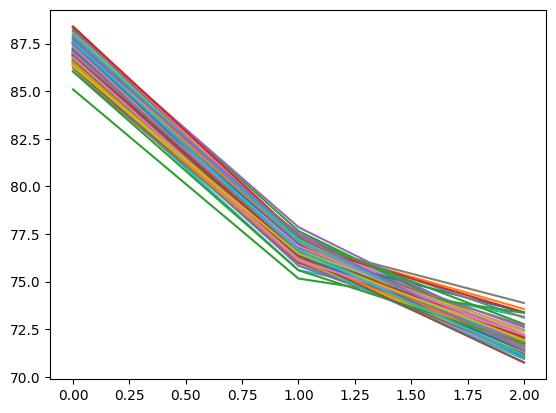

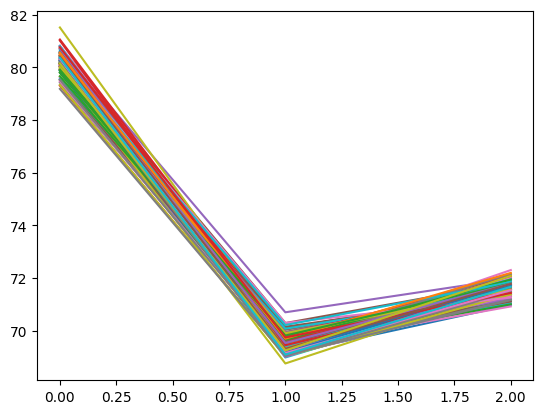

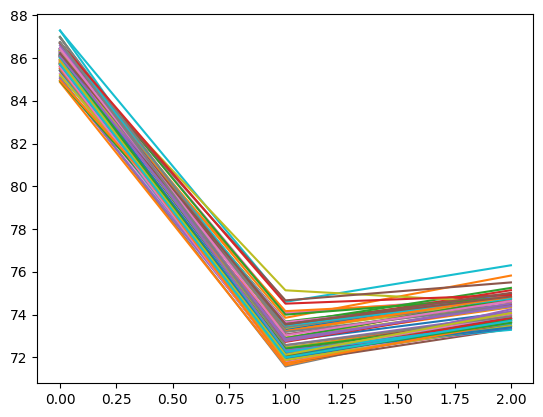

In [29]:
results_irf8 = res.bootstrap_distribution

# for each three values, plot a line plot
for i, g, b in zip(results_irf8[0], results_irf8[1], results_irf8[2]):
    plt.plot([i, g, b])

plt.show()

results_gfi1 = res_gfi1.bootstrap_distribution

# for each three values, plot a line plot
for i, g, b in zip(results_gfi1[0], results_gfi1[1], results_gfi1[2]):
    plt.plot([i, g, b])

plt.show()
results_both = res_both.bootstrap_distribution

for i, g, b in zip(results_both[0], results_both[1], results_both[2]):
    plt.plot([i, g, b])

In [38]:
irf8_data = pd.DataFrame({"erythrocytic": results_irf8[0], "monocytic": results_irf8[1], "granulocytic": results_irf8[2], "id": range(len(results_irf8[0]))}).melt(id_vars = "id")
# rename variable to branch and value to normalised distance
irf8_data = irf8_data.rename(columns = {"variable": "branch", "value": "normalised_distance"})
irf8_data

,id,branch,normalised_distance
0,0,erythrocytic,87.618725
1,1,erythrocytic,88.111296
2,2,erythrocytic,86.969303
3,3,erythrocytic,86.527662
4,4,erythrocytic,87.719367
...,...,...,...
295,95,granulocytic,70.754329
296,96,granulocytic,72.205336
297,97,granulocytic,71.625824
298,98,granulocytic,71.936667


In [39]:
gfi1_data = pd.DataFrame({"erythrocytic": results_gfi1[0], "monocytic": results_gfi1[1], "granulocytic": results_gfi1[2], "id": range(len(results_gfi1[0]))}).melt(id_vars = "id")
# rename variable to branch and value to normalised distance
gfi1_data = gfi1_data.rename(columns = {"variable": "branch", "value": "normalised_distance"})
gfi1_data

,id,branch,normalised_distance
0,0,erythrocytic,80.025498
1,1,erythrocytic,80.126687
2,2,erythrocytic,80.778333
3,3,erythrocytic,80.113254
4,4,erythrocytic,80.777080
...,...,...,...
295,95,granulocytic,71.777775
296,96,granulocytic,71.537948
297,97,granulocytic,71.170128
298,98,granulocytic,72.081600


In [40]:
both_data = pd.DataFrame({"erythrocytic": results_both[0], "monocytic": results_both[1], "granulocytic": results_both[2], "id": range(len(results_both[0]))}).melt(id_vars = "id")
# rename variable to branch and value to normalised distance
both_data = both_data.rename(columns = {"variable": "branch", "value": "normalised_distance"})
both_data

,id,branch,normalised_distance
0,0,erythrocytic,86.449581
1,1,erythrocytic,86.451505
2,2,erythrocytic,86.165339
3,3,erythrocytic,85.870316
4,4,erythrocytic,86.197289
...,...,...,...
295,95,granulocytic,75.018960
296,96,granulocytic,74.634590
297,97,granulocytic,73.921758
298,98,granulocytic,74.073653


In [41]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [45]:
%%R
install.packages("ggstatsplot")

* installing *source* package ‘prismatic’ ...
** package ‘prismatic’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (prismatic)
* installing *source* package ‘ggcorrplot’ ...
** package ‘ggcorrplot’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation pa

Installing package into ‘/home/louise/R/x86_64-pc-linux-gnu-library/4.4’
(as ‘lib’ is unspecified)
also installing the dependencies ‘prismatic’, ‘ggcorrplot’, ‘ggside’, ‘paletteer’

trying URL 'https://cloud.r-project.org/src/contrib/prismatic_1.1.2.tar.gz'
Content type 'application/x-gzip' length 655768 bytes (640 KB)
downloaded 640 KB

trying URL 'https://cloud.r-project.org/src/contrib/ggcorrplot_0.1.4.1.tar.gz'
Content type 'application/x-gzip' length 383178 bytes (374 KB)
downloaded 374 KB

trying URL 'https://cloud.r-project.org/src/contrib/ggside_0.3.1.tar.gz'
Content type 'application/x-gzip' length 3657575 bytes (3.5 MB)
downloaded 3.5 MB

trying URL 'https://cloud.r-project.org/src/contrib/paletteer_1.6.0.tar.gz'
Content type 'application/x-gzip' length 2476216 bytes (2.4 MB)
downloaded 2.4 MB

trying URL 'https://cloud.r-project.org/src/contrib/ggstatsplot_0.13.1.tar.gz'
Content type 'application/x-gzip' length 4192990 bytes (4.0 MB)
downloaded 4.0 MB


The downloaded source

You can cite this package as:
     Patil, I. (2021). Visualizations with statistical details: The 'ggstatsplot' approach.
     Journal of Open Source Software, 6(61), 3167, doi:10.21105/joss.03167


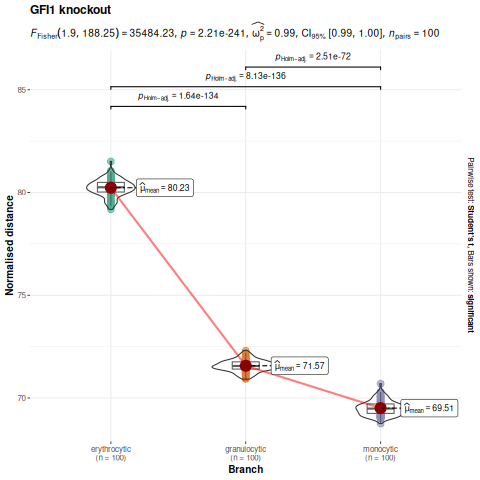

In [46]:
%%R -i gfi1_data
library("ggstatsplot")
ggwithinstats(gfi1_data, x = branch, y = normalised_distance, title = "GFI1 knockout", xlab = "Branch", ylab = "Normalised distance")

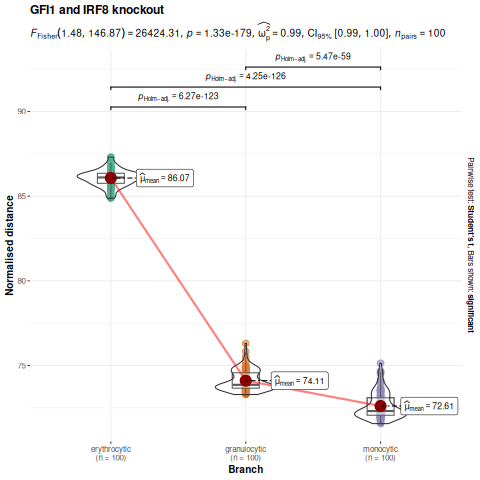

In [47]:
%%R -i both_data
ggwithinstats(both_data, x = branch, y = normalised_distance, title = "GFI1 and IRF8 knockout", xlab = "Branch", ylab = "Normalised distance")

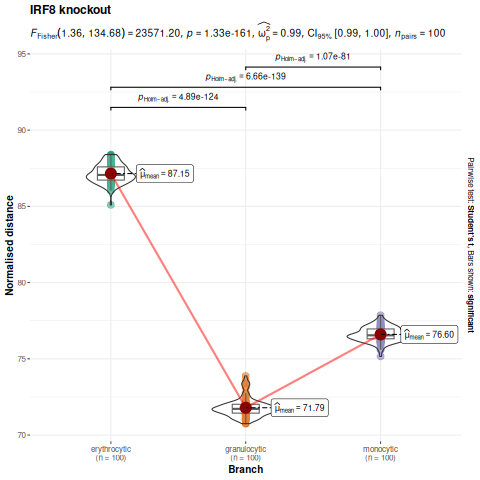

In [48]:
%%R -i irf8_data
ggwithinstats(irf8_data, x = branch, y = normalised_distance, title = "IRF8 knockout", xlab = "Branch", ylab = "Normalised distance")

## 2.4 Plotting

In [49]:
def plot_pseudotime_warping(dataset1, dataset2, warping, lineage, ax = None, key = "X_vis_umap"):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()
    dataset1 = dataset1[np.argsort(dataset1.obs.pseudotime)]
    dataset2 = dataset2[np.argsort(dataset2.obs.pseudotime)]

    erythrocytic = dataset1[dataset1.obs["erythrocytic"] == True]
    granulocytic = dataset1[dataset1.obs["granulocytic"] == True]
    monocytic = dataset1[dataset1.obs["monocytic"] == True]
    # cell is erythrocytic, granulocytic and monocytic
    common = dataset1[(dataset1.obs["granulocytic"] & dataset1.obs["monocytic"] & dataset1.obs["erythrocytic"])]

    colors = ["#315b25", "#ff681c", "#1b2944", "#3abbba"]

    for dataset, color in zip([erythrocytic, monocytic, granulocytic, common], colors):
        dimred = dataset.obsm[key]
        pseudotime = [i for i, x in enumerate(dataset.obs.pseudotime)]
        ax.scatter(pseudotime, dimred[:, 1], c = color, edgecolors="black", linewidths=1.1, s = 60)

    dimred2 = dataset2.obsm[key]
    pseudotime2 = [i*4 for i, x in enumerate(dataset2.obs.pseudotime)]
    ax.scatter(pseudotime2, dimred2[:, 1], c = "#ce8e90", edgecolors="black", linewidths=1.1, s = 60)

    dataset1_part = dataset1#[dataset1.obs.branch_id_id.isin([0, 1, 3, 4])]
    dataset1_part = dataset1_part[dataset1_part.obs[lineage] == True]  
    seq1 = [x - 1 for x in warping[0][1:]]
    seq2 = [x - 1 for x in warping[1][1:]]

    ds1_x = pd.Series([i for i, x in enumerate(dataset1.obs.pseudotime)])[seq2]
    ds1_y = dataset1_part.obsm[key][seq2, 1]
    ds2_x = pd.Series([i*4 for i, x in enumerate(dataset2.obs.pseudotime)])[seq1]
    ds2_y = dataset2.obsm[key][seq1, 1]

    # plot lines
    
    for x1, y1, x2, y2 in zip(ds1_x, ds1_y, ds2_x, ds2_y):
        ax.plot([x1, x2], [y1, y2], c = "black", alpha = 0.3)
    
    ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
    x0 = ax.get_xlim()[0]
    y0 = ax.get_ylim()[0]

    ax.arrow(x0, y0 - 2, 2.2, 0, head_width=0.3, head_length=0.1, fc='k', ec='k')
    ax.arrow(x0, y0 - 2, 0, 5,  head_width=0.1, head_length=0.3, fc='k', ec='k')

    ax.set_xlabel("Pseudotime")
    ax.set_ylabel("UMAP1")
    ax.yaxis.set_label_coords(0.04, 0.2)
    ax.xaxis.set_label_coords(0.11, 0.02)

    ax.set_xticks([])
    ax.set_yticks([])


    return ax

TypeError: 'DTWResult' object is not subscriptable

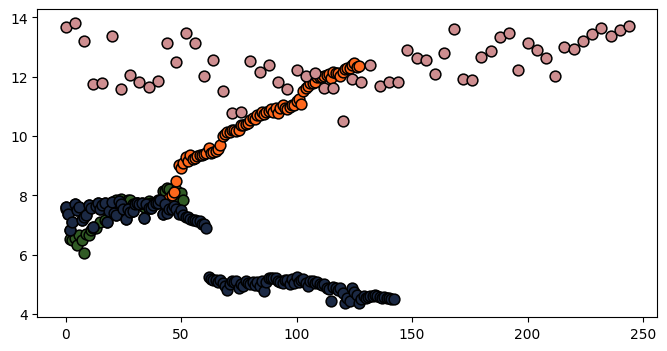

In [50]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(8, 4)
plot_pseudotime_warping(adata, irf8, warping_irf8[2], "granulocytic", ax = ax)
# plot_pseudotime_warping(adata, gfi1, warping_gfi1[1], "monocytic", ax = ax)

fig.legend(["Erythrocytic", "Monocytic", "Granulocytic", "Common", "IRF8 KO"], loc = "upper right", bbox_to_anchor=(0.9, 0.9))

plt.show()